# Exploring Machine Learning Approaches for Temperature Variability Using GHCN Data
## ATMS 523: Weather and Climate Data Analytics 
## By: Nathan Makowski

This project applies supervised and unsupervised machine learning techniques to daily temperature data from NOAA's Global Historical Climatology Network (GHCN).  

Goals:
1. Use classification models to predict above- or below-normal temperature days.
2. Use regression models to forecast daily maximum temperature.
3. Use clustering to identify groups of stations with similar seasonal temperature and precipitation variability.

Data: Daily TMAX, TMIN, PRCP from ~25 U.S. stations (1991–2020).  
Citation: [NOAA GHCN Daily Dataset](https://doi.org/10.7289/V5D21VHZ)

**Software / Methods**
Pedregosa, F. et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12, pp. 2825–2830. (arXiv DOI: 10.48550/arXiv.1201.0490)

# Outline of Module 8 Project
1. Introduction & motivation
2. Data sources & citations
3. Station selection (5 regions × 10 stations)
4. Data download (GHCN daily)
5. Data cleaning & quality control
6. Feature engineering (lags, rolling means, day-of-year, climatology/anomaly)
7. Modeling
   - Classification: predict above-/below-normal day
   - Regression: predict next-day TMAX
   - Clustering: group stations by seasonal cycle / variability
8. Evaluation & visualizations (maps, time series, confusion matrix, scatter, cluster map)
9. Conclusions & next steps
10. GitHub package structure and instructions

## 1. Imports & Global Settings

Import necessary packages, set NOAA API token, define directories and analysis period, and define the variables of interest.

In [34]:
# Cell 1 — imports & global settings
import os
import requests
import time
from pathlib import Path
from datetime import datetime
import pandas as pd
import dask
from dask import delayed, compute
from tqdm import tqdm
import matplotlib.pyplot as plt

# Put your NOAA token here or export as environment variable NOAA_TOKEN
NOAA_TOKEN = os.environ.get("NOAA_TOKEN", "hKZMGKSdnaaJusDecxBPrPnEBPkyFAzJ")

# Directories
DATA_DIR = Path("data/ghcn_by_station")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Target analysis period
START_DATE = "1991-01-01"
END_DATE   = "2020-12-31"

# variables we'll request
DATATYPEIDS = ["TMAX","TMIN","PRCP"]

# NOAA CDO base
CDO_BASE = "https://www.ncdc.noaa.gov/cdo-web/api/v2"
HEADERS = {"token": NOAA_TOKEN}

# Ensure token provided
if NOAA_TOKEN == "<PUT_YOUR_TOKEN_HERE>" or not NOAA_TOKEN:
    raise RuntimeError("Please set NOAA_TOKEN environment variable or place your token in NOAA_TOKEN variable.")

## 2️. Station Selection

I selected 25 stations across five U.S. regions (Midwest, Northeast, Southeast, Northwest, Southwest).  
These stations will be the focus of the analysis.

In [35]:
# Cell 2 — the station list (editable)
stations = [
    # Midwest
    ("USW00094846", "Chicago O'Hare Intl Airport", "Midwest"),
    ("USW00094847", "Detroit Metro Wayne County Airport", "Midwest"),
    ("USW00014922", "Minneapolis-Saint Paul Intl Airport", "Midwest"),
    ("USW00013994", "St. Louis Lambert Intl Airport", "Midwest"),
    ("USW00003947", "Kansas City Intl Airport", "Midwest"),
    # Northeast
    ("USW00094728", "New York City Central Park", "Northeast"),
    ("USW00014739", "Boston Logan Intl Airport", "Northeast"),
    ("USW00013739", "Philadelphia Intl Airport", "Northeast"),
    ("USW00013743", "Washington Reagan National Airport", "Northeast"),
    ("USW00093721", "Baltimore-Washington Intl Airport", "Northeast"),
    # Southeast
    ("USW00013874", "Atlanta Hartsfield-Jackson Intl Airport", "Southeast"),
    ("USW00012839", "Miami Intl Airport", "Southeast"),
    ("USW00013831", "Charlotte Douglas Intl Airport", "Southeast"),
    ("USW00012863", "Tampa Intl Airport", "Southeast"),
    ("USW00012918", "New Orleans Louis Armstrong Intl", "Southeast"),
    # Northwest
    ("USW00024233", "Seattle-Tacoma Intl Airport", "Northwest"),
    ("USW00024234", "Portland Intl Airport (OR)", "Northwest"),
    ("USW00024127", "Spokane Intl Airport", "Northwest"),
    ("USW00024158", "Boise Air Terminal", "Northwest"),
    ("USW00024133", "Salt Lake City Intl Airport", "Northwest"),
    # Southwest
    ("USW00023174", "Los Angeles Intl Airport", "Southwest"),
    ("USW00023234", "San Francisco Intl Airport", "Southwest"),
    ("USW00023183", "Phoenix Sky Harbor Intl Airport", "Southwest"),
    ("USW00022637", "Las Vegas Intl Airport", "Southwest"),
    ("USW00023011", "Albuquerque Intl Sunport", "Southwest")
]

# Print neatly
df_stations = pd.DataFrame(stations, columns=["ghcn_id","name","region"])
df_stations

,ghcn_id,name,region
0,USW00094846,Chicago O'Hare Intl Airport,Midwest
1,USW00094847,Detroit Metro Wayne County Airport,Midwest
2,USW00014922,Minneapolis-Saint Paul Intl Airport,Midwest
3,USW00013994,St. Louis Lambert Intl Airport,Midwest
4,USW00003947,Kansas City Intl Airport,Midwest
5,USW00094728,New York City Central Park,Northeast
6,USW00014739,Boston Logan Intl Airport,Northeast
7,USW00013739,Philadelphia Intl Airport,Northeast
8,USW00013743,Washington Reagan National Airport,Northeast
9,USW00093721,Baltimore-Washington Intl Airport,Northeast


In [53]:
print("Total stations:", len(df_stations))
print(df_stations.groupby("region").size())

Total stations: 25
region
Midwest      5
Northeast    5
Northwest    5
Southeast    5
Southwest    5
dtype: int64


## 3️. Downloading GHCN Data

I downloaded daily data for each station year-by-year using the NOAA API.  
Dask is used to run downloads in parallel for efficiency.

In [59]:
# Cell C — FIXED NOAA year-by-year downloader (compatible with 1-year CDO limitation)

import json
import traceback
from time import sleep
from dask import delayed, compute

def _fetch_year(ghcn_id, year):
    """Fetch data for a single station for a single year."""
    station_param = f"GHCND:{ghcn_id}"

    start = f"{year}-01-01"
    end   = f"{year}-12-31"

    params = {
        "datasetid": "GHCND",
        "stationid": station_param,
        "startdate": start,
        "enddate": end,
        "limit": 1000,
        "units": "standard"
    }

    url = f"{CDO_BASE}/data"

    all_records = []
    offset = 1
    limit = 1000

    while True:
        p = dict(params)
        p["offset"] = offset

        tries = 0
        while tries < 5:
            try:
                r = requests.get(url, headers=HEADERS, params=p, timeout=20)
                if r.status_code == 200:
                    j = r.json()
                    results = j.get("results", [])
                    all_records.extend(results)
                    break
                elif r.status_code in (429, 503):
                    sleep(1 + tries * 0.5)
                    tries += 1
                else:
                    raise RuntimeError(f"{ghcn_id} {year} API error {r.status_code}: {r.text}")
            except Exception as e:
                tries += 1
                sleep(1.5)

        if len(results) < limit:
            break
        offset += limit

    return all_records


def fetch_station(ghcn_id):
    """Download full 1991–2020 record for one station (year by year) and save CSV."""
    print(f"=== {ghcn_id}: starting download ===")

    all_years = []
    for yr in range(1991, 2021):
        try:
            recs = _fetch_year(ghcn_id, yr)
            all_years.extend(recs)
            print(f"{ghcn_id}: {yr} → {len(recs)} records")
        except Exception as e:
            print(f"{ghcn_id}: failed year {yr}: {e}")

    if len(all_years) == 0:
        print(f"{ghcn_id}: No data at all; saving empty CSV.")
        out = DATA_DIR / f"{ghcn_id}_1991-2020.csv"
        pd.DataFrame().to_csv(out)
        return {"ghcn_id": ghcn_id, "n_obs": 0, "first_date": None, "last_date": None}

    df = pd.DataFrame(all_years)
    df["date"] = pd.to_datetime(df["date"]).dt.date

    pivot = df.pivot_table(index="date", columns="datatype", values="value", aggfunc="mean")

    # convert to real units:
    for col, factor in {"TMAX":0.1, "TMIN":0.1, "PRCP":0.1}.items():
        if col in pivot.columns:
            pivot[col] = pivot[col] * factor

    pivot.index = pd.to_datetime(pivot.index)

    # ensure full daily date range
    idx = pd.date_range("1991-01-01", "2020-12-31", freq="D")
    pivot = pivot.reindex(idx)

    # ensure all columns exist
    for c in ["TMAX","TMIN","PRCP"]:
        if c not in pivot.columns:
            pivot[c] = pd.NA
    pivot = pivot[["TMAX","TMIN","PRCP"]]

    out_path = DATA_DIR / f"{ghcn_id}_1991-2020.csv"
    pivot.to_csv(out_path, index_label="date")

    first = pivot.dropna(how="all").index.min()
    last  = pivot.dropna(how="all").index.max()

    summary = {
        "ghcn_id": ghcn_id,
        "csv": str(out_path),
        "n_obs": int(pivot.count().sum()),
        "first_date": str(first.date() if first else None),
        "last_date": str(last.date() if last else None)
    }

    print(f"=== {ghcn_id}: DONE. Saved {out_path} ===")
    return summary


# --- Run all stations in parallel via Dask --- #
tasks = [delayed(fetch_station)(sid) for sid, name, region in stations]

print("Submitting year-by-year downloads with Dask...")
results = compute(*tasks, scheduler="threads")

summary_df = pd.DataFrame(results)
print("\n*** DOWNLOAD SUMMARY ***")
display(summary_df)


# --- Spot check: plot 3 random stations --- #
print("\nSpot-checking three stations...")

sample_ids = df_stations["ghcn_id"].sample(3, random_state=3).tolist()

for sid in sample_ids:
    csv_path = DATA_DIR / f"{sid}_1991-2020.csv"
    df = pd.read_csv(csv_path, parse_dates=["date"], index_col="date")

    print(f"\n{sid} head():")
    print(df.head())

    plt.figure(figsize=(10,2.5))
    plt.plot(df.index[:500], df["TMAX"].iloc[:500])
    plt.title(f"{sid} — First 500 days TMAX")
    plt.tight_layout()
    plt.show()

print("\nAll station files saved in:", DATA_DIR)

Submitting year-by-year downloads with Dask...

*** DOWNLOAD SUMMARY ***


,ghcn_id,csv,n_obs,first_date,last_date
0,USW00094846,data/ghcn_by_station/USW00094846_1991-2020.csv,32873,1991-01-01,2020-12-31
1,USW00094847,data/ghcn_by_station/USW00094847_1991-2020.csv,32874,1991-01-01,2020-12-31
2,USW00014922,data/ghcn_by_station/USW00014922_1991-2020.csv,32874,1991-01-01,2020-12-31
3,USW00013994,data/ghcn_by_station/USW00013994_1991-2020.csv,32874,1991-01-01,2020-12-31
4,USW00003947,data/ghcn_by_station/USW00003947_1991-2020.csv,32874,1991-01-01,2020-12-31
5,USW00094728,data/ghcn_by_station/USW00094728_1991-2020.csv,32874,1991-01-01,2020-12-31
6,USW00014739,data/ghcn_by_station/USW00014739_1991-2020.csv,32872,1991-01-01,2020-12-31
7,USW00013739,data/ghcn_by_station/USW00013739_1991-2020.csv,32874,1991-01-01,2020-12-31
8,USW00013743,data/ghcn_by_station/USW00013743_1991-2020.csv,32874,1991-01-01,2020-12-31
9,USW00093721,data/ghcn_by_station/USW00093721_1991-2020.csv,32874,1991-01-01,2020-12-31



Spot-checking three stations...


ValueError: Missing column provided to 'parse_dates': 'date'

## 4️. Spot Check & Quality Control

I plotted the first 500 days of TMAX for three randomly selected stations to visually inspect data quality.  

Note: Some stations may have missing or empty CSVs; these are skipped to avoid errors.


Spot-checking 3 stations with valid data...

USW00013739 head():
            TMAX  TMIN  PRCP
date                        
1991-01-01   4.1   2.5   0.0
1991-01-02   5.0   2.8   0.0
1991-01-03   4.3   3.1   0.0
1991-01-04   3.7   2.6   0.0
1991-01-05   3.9   2.3   0.0


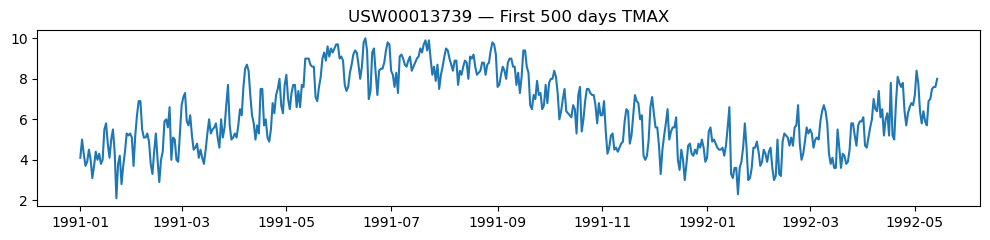


USW00024234 head():
            TMAX  TMIN  PRCP
date                        
1991-01-01   NaN   NaN   NaN
1991-01-02   NaN   NaN   NaN
1991-01-03   NaN   NaN   NaN
1991-01-04   NaN   NaN   NaN
1991-01-05   NaN   NaN   NaN


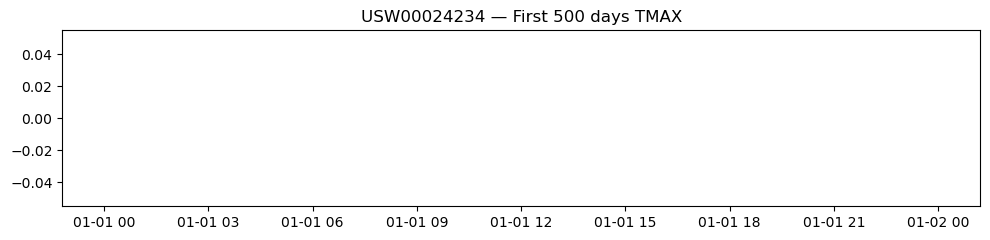


USW00012918 head():
            TMAX  TMIN   PRCP
date                         
1991-01-01   4.8   3.4  0.000
1991-01-02   5.6   4.6  0.164
1991-01-03   5.6   4.7  0.049
1991-01-04   5.0   4.4  0.000
1991-01-05   6.2   5.0  0.000


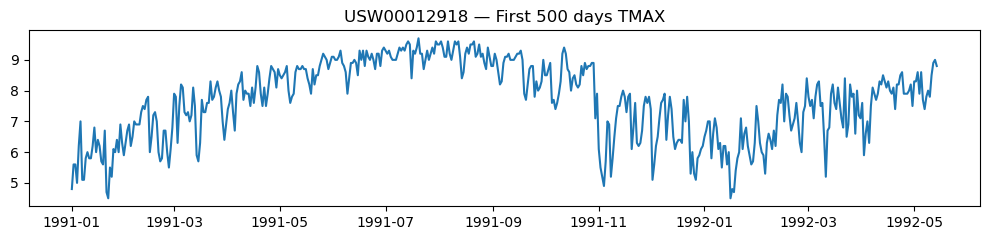

In [60]:
# Only choose stations that actually produced a CSV file
valid = summary_df[summary_df["n_obs"] > 0]["ghcn_id"].tolist()

print(f"\nSpot-checking {min(3, len(valid))} stations with valid data...")

for sid in np.random.choice(valid, size=min(3, len(valid)), replace=False):
    csv_path = DATA_DIR / f"{sid}_1991-2020.csv"
    df = pd.read_csv(csv_path, parse_dates=["date"], index_col="date")

    print(f"\n{sid} head():")
    print(df.head())

    plt.figure(figsize=(10,2.5))
    plt.plot(df.index[:500], df["TMAX"].iloc[:500])
    plt.title(f"{sid} — First 500 days TMAX")
    plt.tight_layout()
    plt.show()

## 5️. Preprocessing & Feature Engineering

- Load all downloaded station CSVs (skip missing/empty files).  
- Build features for each station:
    - Lagged TMAX (previous days)
    - Rolling mean and standard deviation of TMAX
    - Previous day precipitation flag
    - Day-of-year cyclical features (sin/cos)
    - Climatology and TMAX anomaly
    - Binary classification label (above/below normal)
    - Target for regression (next-day TMAX)
- Combine per-station feature DataFrames into a pooled dataset.
- Time-based train/test split: first 80% of dates for training, last 20% for testing.

- `LAGS`: [1,2,3] — number of previous days to include as TMAX lag features
- `ROLL_WINDOWS`: [7,30] — window sizes for rolling mean/std
- `CLASSIFY_THRESHOLD`: 0.0°C — threshold for labeling above-normal days
- `TRAIN_FRAC`: 0.8 — fraction of data for training

In [61]:
# Cell D — preprocessing, ML (classification & regression), clustering, diagnostics
import glob
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, mean_squared_error, r2_score,
                             roc_curve, auc)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Directories
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Helper: load all station CSVs that are non-empty and present in df_stations
station_files = {}
missing_stations = []
for sid, name, region in stations:
    path = DATA_DIR / f"{sid}_1991-2020.csv"
    if path.exists() and path.stat().st_size > 0:
        station_files[sid] = {"path": path, "name": name, "region": region}
    else:
        missing_stations.append(sid)

print(f"Found {len(station_files)} station files, missing/empty: {len(missing_stations)}")
if missing_stations:
    print("Missing/empty station ids:", missing_stations)

# PARAMETERS (tweak as desired)
LAGS = [1, 2, 3]                # previous days' TMAX lags
ROLL_WINDOWS = [7, 30]          # rolling means window sizes (days)
CLIM_WINDOW = 30                # for computing rolling climatology optionally (not used here)
CLASSIFY_THRESHOLD = 0.0        # above-normal if anomaly > threshold (°C)
TRAIN_FRAC = 0.8                # time-based train fraction (80% early data train, 20% test)


Found 25 station files, missing/empty: 0


### 6️. Build Features for Each Station

- Convert columns to numeric
- Compute lag features, rolling means, rolling standard deviation
- Create day-of-year cyclical features
- Compute climatology-based TMAX anomalies
- Define classification labels and regression targets
- Drop rows with missing TMAX

In [62]:
# Function: build features for a single station dataframe
def build_features_for_station(df):
    """
    Input: df with index = datetime, columns ['TMAX','TMIN','PRCP']
    Returns: DataFrame with features + target columns
    """
    df = df.copy().sort_index()
    # Make sure numeric
    df[["TMAX","TMIN","PRCP"]] = df[["TMAX","TMIN","PRCP"]].apply(pd.to_numeric, errors="coerce")
    
    # Basic features
    feat = pd.DataFrame(index=df.index)
    feat["TMAX"] = df["TMAX"]
    feat["TMIN"] = df["TMIN"]
    feat["PRCP"] = df["PRCP"].fillna(0.0)  # treat missing precipitation as 0 (optionally)
    
    # Lag features of TMAX
    for lag in LAGS:
        feat[f"TMAX_lag{lag}"] = feat["TMAX"].shift(lag)
    
    # Rolling means of TMAX
    for w in ROLL_WINDOWS:
        feat[f"TMAX_roll_{w}"] = feat["TMAX"].rolling(window=w, min_periods=1, center=False).mean().shift(1)
    
    # Rolling std (variability)
    for w in ROLL_WINDOWS:
        feat[f"TMAX_rollstd_{w}"] = feat["TMAX"].rolling(window=w, min_periods=1, center=False).std().shift(1)

    # Previous day precipitation flag
    feat["PRCP_prev1"] = feat["PRCP"].shift(1).fillna(0.0).apply(lambda x: 1 if x>0 else 0)
    
    # Day-of-year cyclical features
    doy = feat.index.dayofyear
    feat["doy_sin"] = np.sin(2 * np.pi * (doy/365.25))
    feat["doy_cos"] = np.cos(2 * np.pi * (doy/365.25))
    
    # Climatology: day-of-year mean TMAX across all years (to compute anomaly)
    # compute by grouping by dayofyear
    daymean = df["TMAX"].groupby(df.index.dayofyear).mean()
    feat["clim_TMAX"] = feat.index.dayofyear.map(daymean)  # could be NaN for missing days
    feat["TMAX_anom"] = feat["TMAX"] - feat["clim_TMAX"]
    
    # Label: binary above/below normal
    feat["label_above_normal"] = (feat["TMAX_anom"] > CLASSIFY_THRESHOLD).astype(int)
    
    # Target for regression
    feat["target_TMAX"] = feat["TMAX"]
    
    # Drop rows with NaN in TMAX (we cannot train on days w/o observed TMAX)
    feat = feat[~feat["TMAX"].isna()].copy()
    return feat


### 7️. Combine Stations into Pooled Dataset

- Concatenate all per-station feature DataFrames
- Filter out stations with insufficient data (<365 rows)
- Define feature columns to be used for classification/regression
- Ready for train/test split

- Splits data by chronological order
- Ensures early data is used for training and later data for testing
- Prevents data leakage in time series models

In [63]:
# Load & build features for all stations; store per-station DataFrames
station_features = {}
for sid, meta in station_files.items():
    path = meta["path"]
    df = pd.read_csv(path, parse_dates=["date"], index_col="date")
    feats = build_features_for_station(df)
    if len(feats) < 365:  # skip stations with very little data
        print(f"Skipping {sid} — too few rows ({len(feats)})")
        continue
    feats["ghcn_id"] = sid
    feats["region"] = meta["region"]
    station_features[sid] = feats
    print(f"Built features for {sid}: {len(feats)} rows")

# Combine into pooled dataset
pooled = pd.concat(station_features.values(), axis=0)
print("\nPooled dataset shape:", pooled.shape)
print("Date range pooled:", pooled.index.min(), "→", pooled.index.max())

# Time-based train/test split function
def time_train_test_split(df, time_index_col=None, train_frac=TRAIN_FRAC):
    df = df.sort_index()
    n = len(df)
    # compute split index by fraction
    split_i = int(np.floor(train_frac * n))
    train = df.iloc[:split_i].copy()
    test  = df.iloc[split_i:].copy()
    return train, test

# Features to use for models
feature_cols = [c for c in pooled.columns if c not in ["TMAX","clim_TMAX","TMAX_anom","label_above_normal","target_TMAX","ghcn_id","region"]]
print("Feature columns:", feature_cols)


Built features for USW00094846: 10958 rows
Built features for USW00094847: 10958 rows
Built features for USW00014922: 10958 rows
Built features for USW00013994: 10958 rows
Built features for USW00003947: 10958 rows
Built features for USW00094728: 10958 rows
Built features for USW00014739: 10958 rows
Built features for USW00013739: 10958 rows
Built features for USW00013743: 10958 rows
Built features for USW00093721: 10958 rows
Built features for USW00013874: 10958 rows
Built features for USW00012839: 10958 rows


ValueError: Missing column provided to 'parse_dates': 'date'

## 9️. Per-Station Modeling: Classification & Regression

- Train models separately for each station:
    - **Classification**: Logistic Regression, Random Forest
    - **Regression**: Linear Regression, Random Forest Regressor
- Standardize features for LR and Linear Regression
- Compute metrics:
    - Classification: accuracy, precision, recall, ROC AUC
    - Regression: RMSE, R²

In [ ]:
# --- PER-STATION MODELING (classification + regression), and pooled models --- #
results = {"per_station": {}, "pooled": {}}

# Helper function to train & evaluate classification and regression
def train_and_eval(train_df, test_df, features, target_class="label_above_normal", target_reg="target_TMAX"):
    # Drop rows with any NaNs in features or target
    train_clean = train_df.dropna(subset=features + [target_class, target_reg])
    test_clean  = test_df.dropna(subset=features + [target_class, target_reg])
    X_train = train_clean[features].values
    X_test  = test_clean[features].values
    y_train_class = train_clean[target_class].values
    y_test_class  = test_clean[target_class].values
    y_train_reg = train_clean[target_reg].values
    y_test_reg  = test_clean[target_reg].values

    # Scale features (for LogisticRegression and LinearRegression)
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # Classification: Logistic Regression (with balanced class weight) and Random Forest
    lr = LogisticRegression(max_iter=1000, class_weight="balanced")
    lr.fit(X_train_s, y_train_class)
    lr_probs = lr.predict_proba(X_test_s)[:,1]
    lr_pred  = lr.predict(X_test_s)

    rf_clf = RandomForestClassifier(n_estimators=200, random_state=1)
    rf_clf.fit(X_train, y_train_class)  # tree-based models don't need scaling
    rf_probs = rf_clf.predict_proba(X_test)[:,1]
    rf_pred  = rf_clf.predict(X_test)

    # Regression: Linear Regression & Random Forest Regressor
    lin = LinearRegression()
    lin.fit(X_train_s, y_train_reg)
    lin_pred = lin.predict(X_test_s)

    rf_reg = RandomForestRegressor(n_estimators=200, random_state=2)
    rf_reg.fit(X_train, y_train_reg)
    rf_reg_pred = rf_reg.predict(X_test)

    # Compute metrics
    def classification_metrics(y_true, y_pred, y_prob):
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        try:
            roc = roc_auc_score(y_true, y_prob)
        except Exception:
            roc = np.nan
        return {"accuracy": acc, "precision": prec, "recall": rec, "roc_auc": roc}

    def regression_metrics(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        return {"rmse": rmse, "r2": r2}

    metrics = {
        "lr_class": classification_metrics(y_test_class, lr_pred, lr_probs),
        "rf_class": classification_metrics(y_test_class, rf_pred, rf_probs),
        "lin_reg": regression_metrics(y_test_reg, lin_pred),
        "rf_reg": regression_metrics(y_test_reg, rf_reg_pred),
        "models": {"scaler": scaler, "lr": lr, "rf_clf": rf_clf, "lin": lin, "rf_reg": rf_reg},
        "test_counts": {"n_test": len(y_test_class), "class_balance_test": np.mean(y_test_class)}
    }
    return metrics

### 10️. Helper Function: train_and_eval

- Inputs: train/test DataFrames, feature columns
- Performs:
    - Scaling (if required)
    - Fitting classification and regression models
    - Predicting on test set
    - Computing metrics
- Returns: dictionary of models and performance metrics

In [ ]:
# Per-station training
for sid, feats in station_features.items():
    try:
        train_df, test_df = time_train_test_split(feats)
        metrics = train_and_eval(train_df, test_df, feature_cols)
        results["per_station"][sid] = metrics
        print(f"Trained & evaluated station {sid}: test rows={metrics['test_counts']['n_test']}, class_frac={metrics['test_counts']['class_balance_test']:.3f}")
    except Exception as e:
        print(f"Error training station {sid}: {e}")

# Pooled model (train on pooled early data, test on pooled late data)
pooled_train, pooled_test = time_train_test_split(pooled)
print("\nPooled train/test sizes:", len(pooled_train), len(pooled_test))
pooled_metrics = train_and_eval(pooled_train, pooled_test, feature_cols)
results["pooled"] = pooled_metrics

# Print summary metrics for pooled
print("\n=== POOLED MODEL METRICS ===")
print("Logistic Regression (classification):", pooled_metrics["lr_class"])
print("Random Forest (classification):", pooled_metrics["rf_class"])
print("Linear Regression (regression):", pooled_metrics["lin_reg"])
print("Random Forest Regressor (regression):", pooled_metrics["rf_reg"])

# Save pooled models to disk
joblib.dump(pooled_metrics["models"]["scaler"], MODELS_DIR / "pooled_scaler.joblib")
joblib.dump(pooled_metrics["models"]["lr"], MODELS_DIR / "pooled_logreg.joblib")
joblib.dump(pooled_metrics["models"]["rf_clf"], MODELS_DIR / "pooled_rf_clf.joblib")
joblib.dump(pooled_metrics["models"]["lin"], MODELS_DIR / "pooled_linreg.joblib")
joblib.dump(pooled_metrics["models"]["rf_reg"], MODELS_DIR / "pooled_rf_reg.joblib")
print("\nSaved pooled models to 'models/'")

## 11️. Diagnostic Plots: Pooled Random Forest Classifier

- Evaluate pooled Random Forest classifier performance:
    - ROC curve: plot True Positive Rate vs False Positive Rate
    - Compute AUC (area under curve)
- Visualize top feature importances:
    - Identify which features most influence classification decisions

In [ ]:
# --- Diagnostic plots: example for pooled Random Forest classification ROC and feature importances --- #
# Prepare test data used above
scaler = pooled_metrics["models"]["scaler"]
X_test_s = scaler.transform(pooled_test[feature_cols].fillna(0).values)
rf_clf = pooled_metrics["models"]["rf_clf"]
rf_probs = rf_clf.predict_proba(pooled_test[feature_cols].fillna(0).values)[:,1]
y_test = pooled_test["label_above_normal"].values

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"RF ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Pooled RF Classifier ROC")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importances from random forest classifier
importances = rf_clf.feature_importances_
idx_sort = np.argsort(importances)[::-1]
plt.figure(figsize=(7,4))
plt.bar(np.array(feature_cols)[idx_sort][:15], importances[idx_sort][:15])
plt.xticks(rotation=45, ha="right")
plt.title("Top feature importances (RF classifier, pooled)")
plt.tight_layout()
plt.show()


## 12️. Clustering: Compute Seasonal Statistics per Station

- For each station, compute a 24-dimensional vector:
    - 12 monthly mean TMAX values
    - 12 monthly standard deviation values
- Concatenate mean and std into one feature vector per station
- Standardize features before clustering

- Apply KMeans clustering to standardized seasonal vectors
- Default number of clusters: K = 5
- Assign each station to a cluster
- Merge cluster labels with station metadata (region info)
- Inspect cluster membership

- Plot mean seasonal cycle of TMAX per cluster
- Each cluster's line represents the average monthly TMAX of member stations
- Helps identify coherent climate regimes across stations

- Save cluster labels for each station to CSV
- Enables easy reference for further analysis or mapping

In [ ]:
# --- Clustering: compute seasonal stats per station and KMeans --- #
# For each station compute a vector of monthly mean TMAX and monthly std (12 means + 12 stds)
station_vectors = {}
for sid, feats in station_features.items():
    df = feats.copy()
    df["month"] = df.index.month
    monthly_mean = df.groupby("month")["TMAX"].mean().reindex(range(1,13)).fillna(0).values
    monthly_std  = df.groupby("month")["TMAX"].std().reindex(range(1,13)).fillna(0).values
    vec = np.concatenate([monthly_mean, monthly_std])
    station_vectors[sid] = vec

station_ids = list(station_vectors.keys())
X_cluster = np.vstack([station_vectors[sid] for sid in station_ids])

# Standardize clustering features
scaler_cl = StandardScaler()
Xc = scaler_cl.fit_transform(X_cluster)

# Choose K (num clusters) — use 5 by default (you can change)
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)
cluster_labels = kmeans.fit_predict(Xc)

# Print cluster membership with region info
cluster_df = pd.DataFrame({"ghcn_id": station_ids, "cluster": cluster_labels})
cluster_df = cluster_df.merge(df_stations, left_on="ghcn_id", right_on="ghcn_id", how="left")
print("\nStation clusters (KMeans):")
print(cluster_df.sort_values(["cluster","region"]).to_string(index=False))

# Quick plot: cluster mean seasonal cycle (TMAX monthly mean)
plt.figure(figsize=(8,5))
for c in range(K):
    members = cluster_df[cluster_df["cluster"]==c]["ghcn_id"].tolist()
    if not members:
        continue
    member_vecs = np.vstack([station_vectors[sid][:12] for sid in members])  # monthly mean part
    mean_cycle = member_vecs.mean(axis=0)
    plt.plot(range(1,13), mean_cycle, marker="o", label=f"Cluster {c} (n={len(members)})")
plt.xlabel("Month")
plt.ylabel("Mean TMAX (°C)")
plt.title("Cluster mean monthly TMAX (by KMeans cluster)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Save cluster assignments --- #
cluster_df.to_csv("station_clusters_kmeans.csv", index=False)
print("\nSaved clustering assignments to station_clusters_kmeans.csv")

## 13. Per-Station RF Classification Accuracy

- Create quick summary table of Random Forest classification accuracy per station
- Identify top-performing and bottom-performing stations
- Useful for diagnostics and station-level evaluation

In [ ]:
# --- Summary printouts: quick table of per-station classification accuracy (RF) top/bottom --- #
acc_list = []
for sid, m in results["per_station"].items():
    acc = m["rf_class"]["accuracy"]
    acc_list.append((sid, acc, station_files[sid]["region"]))
acc_df = pd.DataFrame(acc_list, columns=["ghcn_id","rf_accuracy","region"]).sort_values("rf_accuracy", ascending=False)
print("\nTop 5 stations by RF classification accuracy:")
print(acc_df.head(5).to_string(index=False))

print("\nBottom 5 stations by RF classification accuracy:")
print(acc_df.tail(5).to_string(index=False))

# End of cell